# Kaggle machine learning competition: Phishing Email Detection

# 1. Import modules

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
plt.rcParams["figure.facecolor"] = "white"

# 2. Read and split the data

In [4]:
from sklearn.model_selection import train_test_split

def process_data(data):
    # return data.str.encode("ascii", "ignore").str.decode("ascii")
    return data

home_dir = os.path.expanduser("~")
local_dir = f"{home_dir}/github/KaggleCompetitionSpamNotSpam/datasets"

train_data = pd.read_csv(f"{local_dir}/train.csv", index_col=0)
test_data = pd.read_csv(f"{local_dir}/test.csv", index_col=0)

train_data["email"] = process_data(train_data["email"])
test_data["email"] = process_data(test_data["email"])

train, val = train_test_split(train_data, test_size=0.15, random_state=17, stratify=train_data["label"])

print(f"Train data shape: {train.shape}")
print(f"Validation data shape: {val.shape}")

Train data shape: (6386, 4)
Validation data shape: (1127, 4)


# 3. Extract features from the dataset

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(analyzer="word", ngram_range=(1, 2), lowercase=True)

X_train_counts = count_vect.fit_transform(train["email"])
ser_features_names = pd.Series(count_vect.get_feature_names_out())
ser_features_names.to_frame("feature_names").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663546 entries, 0 to 663545
Data columns (total 1 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   feature_names  663546 non-null  object
dtypes: object(1)
memory usage: 5.1+ MB


# 4. Feature extraction - Find importance of words

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
ser_features_tfidf = pd.Series(tfidf_transformer.idf_)
ser_features_tfidf.to_frame("importance").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663546 entries, 0 to 663545
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   importance  663546 non-null  float64
dtypes: float64(1)
memory usage: 5.1 MB


# 5. Model Selection, training, and testing

In [7]:
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

text_clf = SGDClassifier(loss="hinge", penalty="l2",
                         alpha=1e-6, random_state=17,
                         max_iter=2e3, tol=1e-12, 
                         fit_intercept=True)

text_clf.fit(X_train_tfidf, train["label"])  
y_pred = text_clf.predict(tfidf_transformer.transform(count_vect.transform(val["email"])))
    
print(metrics.classification_report(val["label"], y_pred, target_names=["not spam", "spam"], digits=4))                         

              precision    recall  f1-score   support

    not spam     0.9952    0.9952    0.9952       838
        spam     0.9862    0.9862    0.9862       289

    accuracy                         0.9929      1127
   macro avg     0.9907    0.9907    0.9907      1127
weighted avg     0.9929    0.9929    0.9929      1127



# 6. Visualize results

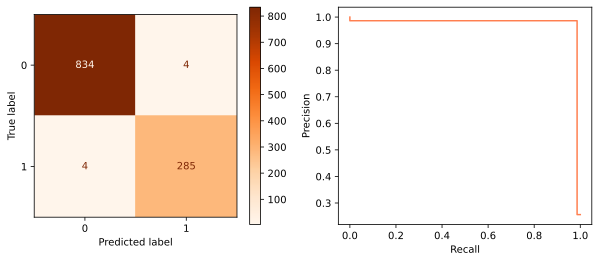

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

cm = metrics.confusion_matrix(val["label"], y_pred)
cm_display = metrics.ConfusionMatrixDisplay(cm).plot(ax=axes[0], cmap=plt.cm.Oranges)

precision, recall, _ = metrics.precision_recall_curve(val["label"], y_pred)
pr_display = metrics.PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=axes[1], color="coral")
plt.savefig(f"{local_dir}/confusion_matrix.svg", dpi=1200, bbox_inches="tight")

# 7. Submit the results

In [7]:
y_submit = text_clf.predict(tfidf_transformer.transform(count_vect.transform(test_data["email"])))

df_submit = test_data.reset_index()[["id"]].copy().set_index("id")
df_submit["label"] = y_submit
df_submit.to_csv(f"{local_dir}/submit_REV2.csv")